In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import style
import random as rand
%matplotlib inline

import qiskit.quantum_info as qi
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit, execute, BasicAer
from qiskit_aer import AerSimulator
from qiskit import Aer, transpile
from qiskit.primitives import Estimator

# Demonstrate the violation of the Bell inequality

In this excercise, you will simulate an experiment to demonstrate the violation of the Bell inequality using Qiskit estimator.

The 2022 Nobel Prize for Physics was awarded to Alain Aspect, John Clauser and Anton Zeilinger in part for their pioneering work in quantum information science, and in particular, their experiments with entangled photons demonstrating violation of Bell’s inequalities. 

The violation of the Bell inequality is used to show that quantum mechanics is incompatible with local hidden-variable theories. This is an important experiment for understanding the foundation of quantum mechanics. An experimental method to realise Bell’s inequalitywas proposed by Clauser, Horne, Shimony, and Holt (CHSH) in 1969.

### CHSH game

The game involves two players (Alice and Bob) who play against Charlie. Alice and Bob can discuss and pick a strategy before the game starts, but are not allowed to communicate after the beginning of the game. Two random bits <b>x</b> and <b>y</b> are generated by Charlie and are given as inputs to Alice and Bob respectively. Alice and Bob do not know each other's inputs. They can manipulate their own input however they wish, according to their strategy, and then choose a bit to output. Alice will output a bit <b>a</b> and Bob a bit <b>b</b>.

Alice and Bob win against the house if the following condition is satisfied:

$$ x \cdot y = a \oplus b $$

## Classical strategy

Let's first play the game using a deterministic classical strategy. Remember, this means that Alice can only devise a strategy based on her value of the input bit <b>x</b> and Bob according to its input value <b> y </b> and they cannot communicate with each other. Here are a few possible strategies:

1) output = input

2) output = NOT(input)

3) always output = 1 

4) always output = 0

The strategy can be encoded into the function:

###  1. Include other strategies from the list into the function

In [2]:
def PlayerChoice(strategy, inp):
    if (strategy == 1):
        return inp
    if (strategy == 2):
        return 1^inp
    if (strategy == 3):
        return 1
    if (strategy == 4):
        return 0
    else:
        print("INVALID choice")
        return 100

### 2. Choosing various strategies for Alice and Bob, find the best classical strategy to win the game and the best result

In [3]:
AliceStrategy = 1
BobStrategy = 2

# The number of games to be played
N = int(1e5)

timesWin = 0 # counts games won

# play the game N times
for i in range(N):
    
    # generates two random inputs, x and y, to be given to Alice and Bob
    x = rand.randint(0,1) # input for Alice
    y = rand.randint(0,1) # input for Bob
    
    # generates Alice's and Bob's output
    a = PlayerChoice(AliceStrategy, x) # Alice's output
    
    b = PlayerChoice(BobStrategy, y) # Bob's output

    # check if the condition for winning the game is met
    if(x*y == a^b):
        timesWin += 1 # increase thes won games' counter if the condition to win the game is met

probWin = timesWin/(N) # winning probability

print('Alice and Bob won the game with probability: %.2f percent' %(probWin*100))

Alice and Bob won the game with probability: 75.04 percent


### 3. Find statistical error given by the number of times $N$ the experiment is repeated

In [4]:
error = ( (N-timesWin)*(0-probWin)**2 + timesWin*(1-probWin)**2 )**(1/2) / N
print('Alice and Bob won the game with probability: %.2f +- %.2f percent' %(probWin*100, error*100))

Alice and Bob won the game with probability: 75.04 +- 0.14 percent


#### Error calculation:


<img src="Problem_3.png" height="300"/>

### 4. What is the maximum winning probability with the classical strategy?

#### **Answer: 75%**.

##### Since the order of strategy choices don't matter, the following are all the possible combinations and probability for each combination.

<img src="Problem_1.png" height="300"/>


## Quantum Strategy
Before the game starts Alice and Bob share an entangled bipartite state.

$$ |\Psi\rangle=\frac{1}{\sqrt{2}}(|0,0\rangle+|1,1\rangle) $$

They define a measurement bases denoted by $v_{i}(\theta_{A,B})$ such that:

$$
|v_{0}(\theta)\rangle = \cos(\theta / 2)|0\rangle + \sin(\theta / 2)|1\rangle
$$
$$
|v_{1}(\theta)\rangle = -\sin(\theta / 2)|0\rangle + \cos(\theta / 2)|1\rangle
$$

Based on the input values from Charlie, Alice and Bob choose a measurement bases.

Lets calculate the winning probability if Alice and Bob rotate their bases to maximize the winning probability.


### 5. Generate the circuit with two entangled qubits 
Both qubits  will be measured in  the basis sweeped between  0 and  2𝜋 with parameter $\theta$. 

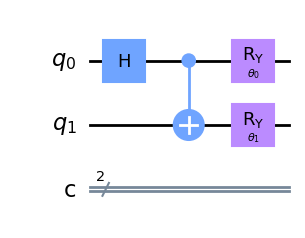

In [5]:
theta1 = Parameter("$\\theta_0$")
theta2 = Parameter("$\\theta_1$")

qcCHSH = QuantumCircuit(2, 2)

qcCHSH.h(0)
qcCHSH.cx(0,1)

qcCHSH.ry(theta1, 0)
qcCHSH.ry(theta2, 1)

qcCHSH.draw('mpl')

### 6. Write down the quantum state it generates 
Try various $\theta$ values.

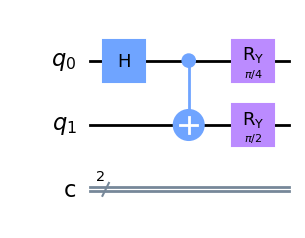

In [6]:
state = qi.Statevector.from_int(0, 2**2)

theta1Value = np.pi/4
theta2Value = np.pi/2

qcCHSH_bind = qcCHSH.bind_parameters({theta1: theta1Value, theta2: theta2Value})
qcCHSH_bind.draw('mpl')

In [7]:
final_state = state.evolve(qcCHSH_bind)
final_state.draw('latex')

<IPython.core.display.Latex object>

### 7. Is the resulting state always entangled?

#### **Answer: Yes**

##### The resulting state has the form ${\ket{0} \otimes (x\ket{0} - y\ket{1}) + \ket{1} \otimes (y\ket{0} + x\ket{1})}$, where ${x = \cos{\frac{\theta_1 - \theta_2}{2}}}$, and ${y = \sin{\frac{\theta_1 - \theta_2}{2}}}$. This is alwasy an entangled state for all values of $x$ and $y$, except for $x=0=y$ which destroys the state and thus trivial.

<img src="Problem_5.png" height="600"/>

### 8. Add measurement to the circuit

Now we need observables from which to compute the expectation values. In our case we are looking at orthogonal bases for each qubit, letting the parameterized  Y−rotation for the first qubit sweep the measurement basis nearly continuously with respect to the second qubit basis.  


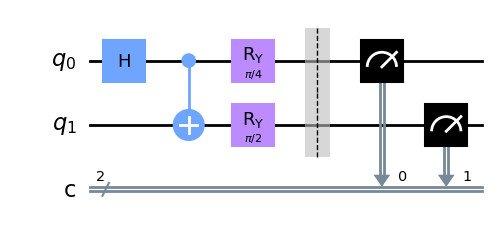

In [8]:
# range(2) = [0,1]
qcCHSH_bind.barrier(range(2))
qcCHSH_bind.measure(range(2), range(2))

qcCHSH_bind.draw('mpl')


### 9. Write down the measurement strategies for Alice and Bob for the quantum game

1) output $\theta =0 $

2) output $\theta =  $ random angles from 0 to ${2\pi}$

3) output $\theta =0 $ for inp = 0 and $\theta =\pi/2 $ for inp =1

4) output $\theta =\pi/4 $ for inp = 0 and $\theta =-\pi/4 $ for inp =1

In [9]:
def QuantumPlayerChoice(strategy, inp):
    if (strategy == 1):
        return 0
    if (strategy == 2):
        return rand.uniform(0, 2*np.pi)
    if (strategy == 3):
        return inp * np.pi/2
    if (strategy == 4):
        return np.pi/4 * (1 - inp*2)
    else:
        print("INVALID choice")
        return 100

### 10. In analogy with the classical game finalise the script for the quantum game
Find the best measurement strategies for Alice and Bob to maximize the probability

In [10]:
AliceStrategy = 1
BobStrategy  = 3

# set parameters of the quantum run of the game 
shots = 1 # set how many times the circuit is run, accumulating statistics about the measurement outcomes 
backend = BasicAer.get_backend('qasm_simulator') # set the machine where the quantum circuit is to be run   

# fixes the numbers of games to be played
N = 1000

# initializes counters used to keep track of the numbers of games won and played by Alice an Bob
timesWin = 0 # counts games won

# play N games
for i in range(N):

    x = rand.randint(0,1) # input for Alice
    y = rand.randint(0,1) # input for Bob
    
    # The main part of Alice and Bob quantum strategy is to fix different rotation angles for their qubit according to the input x,y
    theta1Value = QuantumPlayerChoice(AliceStrategy, x) # fixes Alice's rotation for her qubit
    theta2Value = QuantumPlayerChoice(BobStrategy, y) # fixes Bob's rotation for his qubit
    
    # fix theta1 and theta2 values for the qcCHSH circuit
    qcCHSH_bind = qcCHSH.bind_parameters({theta1: theta1Value, theta2: theta2Value})

    # measure  the value of the qubits for Alice and Bob
    qcCHSH_bind.save_statevector()

    sim = AerSimulator()
    compiled_qcCHSH_bind = transpile(qcCHSH_bind, sim)
    job = sim.run(compiled_qcCHSH_bind)

    output = job.result()
    # out_vector = output.get_statevector()

    # executes circuit and store the output of the measurements
    data = output.get_counts() # extract the outcomes and their statistics from the result of the execution

    # reads the result of the measurements of the quantum system
    for outcomes in data.keys():
        out = outcomes

    # converts the result of the measurements contained in the classical register as string '00', '01', '10', '11',
    # which are the answers of Alice(a) and Bob (b), from a 'string' type  to 'integer' type 
    if(out == '00'):
        a = 0; b = 0
    if(out == '01'):
        a = 1; b = 0    
    if(out == '10'):
        a = 0; b = 1
    if(out == '11'):
        a = 1; b = 1

    # check if the condition for winning the game is met
    if (x*y == a^b):
        timesWin += 1 # increase thes won games' counter if the condition to win the game is met

probWin = timesWin/N

print('Alice and Bob won the game with probability: ', probWin*100, '%')

Alice and Bob won the game with probability:  73.4 %


### 11. Find statistical error given by the number of times  𝑁  the experiment is repeated

In [11]:
error = ( (N-timesWin)*(0-probWin)**2 + timesWin*(1-probWin)**2 )**(1/2) / N
print('Alice and Bob won the game with probability: %.2f +- %.2f percent' %(probWin*100, error*100))

Alice and Bob won the game with probability: 73.40 +- 1.40 percent


## CHSH inequality violation

Experimental implementation of the experiment is done using the CHSH inequality. For this experiment, you create an entangled pair and measure each qubit on two different bases. We will label the bases for the first qubit $a_1$ and $a_2$ and the bases for the second qubit $b_1$ and $b_2$.  This allows us to compute the CHSH quantity $S$:

$$S = a_1(b_1-b_2) + a_2(b_1+b_2)$$

Assuming that the qubits measured in these different bases, each observable is either $+1$ or $-1$. In the case of separable state to have maximum value, one of the terms $b_1\pm b_2$ must be $0$, and the other must be $\pm 2$.  Therefore, $S = \pm 2$. The average value of $S$ must satisfy the inequality:

$$|\langle S \rangle|\leq 2.$$

Expanding $S$ in terms of $a_1$, $a_2$, $b_1$, and $b_2$ results in:

$$|\langle S \rangle| = |\langle a_1b_1 \rangle - \langle a_1b_2 \rangle + \langle a_2b_1 \rangle + \langle a_2b_2 \rangle| \leq 2$$

You can define another CHSH quantity $S_2$:

$$S_2 = a_1(b_1+b_2) - a_2(b_1-b_2),$$

This leads to another inequality:

$$|\langle S_2 \rangle| = |\langle a_1b_1 \rangle + \langle a_1b_2 \rangle - \langle a_2b_1 \rangle + \langle a_2b_2 \rangle| \leq 2$$

If quantum mechanics can be described by local hidden variable theories, the previous inequalities must hold true.

The form of the CHSH inequality linked to the experiment can be written as 
$|S|\leq 2,$ where

$$S = E(a_1, b_1) - E\left(a_1, b_2\right) + E\left(a_2, b_1\right) + E\left(a_2, b_2\right)$$

$$S_2 = E(a_1, b_1) + E\left(a_1, b_2\right) - E\left(a_2, b_1\right) + E\left(a_2, b_2\right)$$

$a$ and $a'$ are detector settings on Alice side, $b$ and $b'$ on Bob side, the four combinations being tested in separate subexperiments. The terms $E(a, b)$ etc. are the quantum correlators of the particle pairs, defined to be the expectation value of the product of the "outcomes" of the experiment, i.e. the statistical average of $a_1(a_2)·b_1(b_2)$, where $a_{12}$ and $b_{12}$ are the separate outcomes, using the coding +1 for the '+' channel and -1 for the - channel.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/Two_channel_bell_test.svg/2880px-Two_channel_bell_test.svg.png" height="300"/>

### 12. Find optimal condition for CHSH inequality violation

Conduct subexperiments, corresponding to the four terms $E(a, b)$. 

For each selected value of $a$ and $b$, the numbers of coincidences in each category $\left\{ N_{++}, N_{--}, N_{+-}, N_{-+} \right\}$ are recorded.  The experimental estimate for correlators $E(a, b)$ is then calculated as:
$$ E = \frac {N_{++}  - N_{+-} - N_{-+} + N_{--}} {N_{++}  + N_{+-} + N_{-+}+ N_{--}}$$

Calculate CHSH inequality violation and find angles where the local hidden-variable theories can be ruled out.

##### By varying the angle between $\theta_1$  and $\theta_2$ angles defining the Alice's and Bob's bases, find the maximum value of $S$ and $S_2$ parameters

In [12]:
qcCHSH.measure([0,1], [0,1])

In [13]:
simulator = AerSimulator()

thetas1 = np.array([0, np.pi/2])
phase = np.pi/4
thetas2 =  thetas1 + phase
thetas = [{theta1: [th1], theta2: [th2]} for th1 in thetas1 for th2 in thetas2]

batchCircuits = [qcCHSH] * 4
Nshots = int(1e5)

resultCHSH = simulator.run(batchCircuits, parameter_binds=thetas, shots=Nshots).result()

tmp = resultCHSH.get_counts()

E = np.zeros((4,1))
for i in range(4):
    E[i] = (tmp[i]['00'] - tmp[i]['01'] - tmp[i]['10'] + tmp[i]['11']) / Nshots

print(E)

[[ 0.7064 ]
 [-0.70874]
 [ 0.70694]
 [ 0.7051 ]]


In [14]:
# write down the expression for CHSH S and S2 parameters and calculate them
SCHSH = E[0] - E[1] + E[2] + E[3]
SCHSH2 = E[0] + E[1] - E[2] + E[3]

print('CHSH parameter: %.3f' %(SCHSH))
print('CHSH2 parameter: %.3f' %(SCHSH2))

CHSH parameter: 2.827
CHSH2 parameter: -0.004


### 13. Calculate the CHSH parameters S and S2 for different angles between their bases using the loop

In [15]:
simulator = AerSimulator()
Nshots = int(1e5)

Nphases = 21 # number of angles to vary
phases = np.linspace(0, np.pi, Nphases) + np.pi/100
arraySCHSH = np.zeros((Nphases))
arraySCHSH2 = np.zeros((Nphases))

for j, ph in enumerate(phases):
    thetas1 = np.array([0, np.pi/2])
    thetas2 =  thetas1 + ph
    thetas = [{theta1: [th1], theta2: [th2]} for th1 in thetas1 for th2 in thetas2]

    batchCircuits = [qcCHSH] * 4

    resultCHSH = simulator.run(batchCircuits, parameter_binds=thetas, shots=Nshots).result()

    tmp = resultCHSH.get_counts()

    E = np.zeros((4,1))
    for i in range(4):
        E[i] = (tmp[i]['00'] - tmp[i]['01'] - tmp[i]['10'] + tmp[i]['11']) / Nshots

    arraySCHSH[j] = E[0] - E[1] + E[2] + E[3]
    arraySCHSH2[j] = E[0] + E[1] - E[2] + E[3]

#### Plot the result

Text(0, 0.5, 'Correlator')

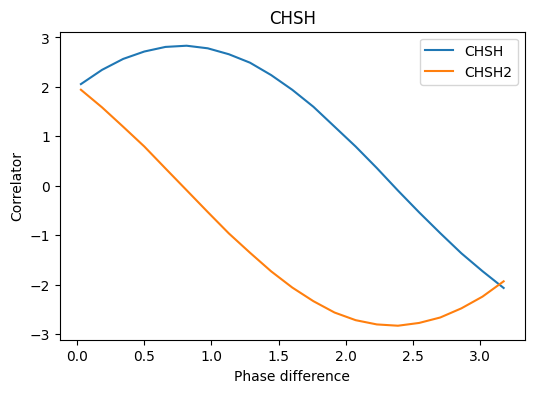

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_title('CHSH')
ax.plot(phases, arraySCHSH, label='CHSH')
ax.plot(phases, arraySCHSH2, label='CHSH2')

ax.legend()
ax.set_xlabel("Phase difference")
ax.set_ylabel("Correlator")


### 14. Find the maximum CHSH value reached within quantum mechanics

In [17]:
phaseDiff = 0
max = 0
for j, ph in enumerate(phases):
    if (abs(arraySCHSH[j]) > abs(max)):
        phaseDiff = ph
        max = arraySCHSH[j]

print('CHSH - phase difference:', phaseDiff, ', correlator:', max)

CHSH - phase difference: 0.8168140899333463 , correlator: 2.8321


In [18]:
phaseDiff = 0
max = 0
for j, ph in enumerate(phases):
    if (abs(arraySCHSH2[j]) > abs(max)):
        phaseDiff = ph
        max = arraySCHSH2[j]

print('CHSH - phase difference:', phaseDiff, ', correlator:', max)

CHSH - phase difference: 2.3876104167282426 , correlator: -2.8293999999999997


### 15. Check the CHSH violation after generating a bit different Bell state

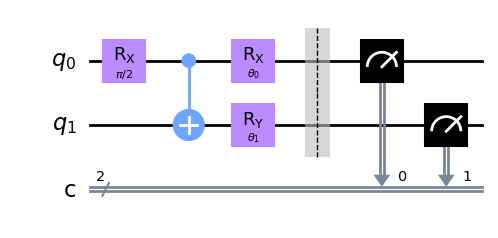

In [2]:
# check the document to see the circuit to generate
theta1 = Parameter("$\\theta_0$")
theta2 = Parameter("$\\theta_1$")

qcCHSH = QuantumCircuit(2, 2)

qcCHSH.rx(np.pi/2, 0)
qcCHSH.cx(0,1)

qcCHSH.rx(theta1, 0)
qcCHSH.ry(theta2, 1)

qcCHSH.barrier([0,1])
qcCHSH.measure([0,1], [0,1])

qcCHSH.draw('mpl')

#### **Comment**: We see that the input state changed from ${\ket{\Phi^+} = \frac{1}{\sqrt{2}} (\ket{00} + \ket{11})}$ to ${\ket{\Phi^+} = \frac{1}{\sqrt{2}} (\ket{00} - i\ket{11})}$.
##### By changing the measurement bases on $q_0$ from $R_y$ to $R_x$, we reobtain the violation.

<img src="Problem_16.png" height="300"/>

### 16. Try to find a way to get the violation using this state
##### What bases modification is needed?

In [3]:
simulator = AerSimulator()
Nshots = int(1e5)

Nphases = 21 # number of angles to vary
phases = np.linspace(0, np.pi, Nphases) + np.pi/100
arraySCHSH = np.zeros((Nphases))
arraySCHSH2 = np.zeros((Nphases))

for j, ph in enumerate(phases):
    thetas1 = np.array([0, np.pi/2])
    thetas2 =  thetas1 + ph
    thetas = [{theta1: [th1], theta2: [th2]} for th1 in thetas1 for th2 in thetas2]

    batchCircuits = [qcCHSH] * 4

    resultCHSH = simulator.run(batchCircuits, parameter_binds=thetas, shots=Nshots).result()

    tmp = resultCHSH.get_counts()

    E = np.zeros((4,1))
    for i in range(4):
        E[i] = (tmp[i]['00'] - tmp[i]['01'] - tmp[i]['10'] + tmp[i]['11']) / Nshots

    arraySCHSH[j] = E[0] - E[1] + E[2] + E[3]
    arraySCHSH2[j] = E[0] + E[1] - E[2] + E[3]

Text(0, 0.5, 'Correlator')

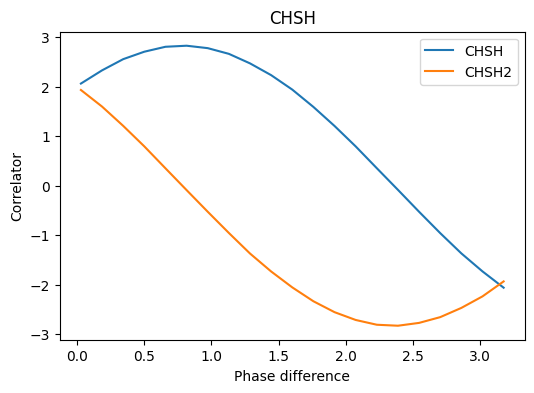

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_title('CHSH')
ax.plot(phases, arraySCHSH, label='CHSH')
ax.plot(phases, arraySCHSH2, label='CHSH2')

ax.legend()
ax.set_xlabel("Phase difference")
ax.set_ylabel("Correlator")

In [5]:
phaseDiff = 0
max = 0
for j, ph in enumerate(phases):
    if (abs(arraySCHSH[j]) > abs(max)):
        phaseDiff = ph
        max = arraySCHSH[j]

print('CHSH - phase difference:', phaseDiff, ', correlator:', max)

CHSH - phase difference: 0.8168140899333463 , correlator: 2.8288


In [6]:
phaseDiff = 0
max = 0
for j, ph in enumerate(phases):
    if (abs(arraySCHSH2[j]) > abs(max)):
        phaseDiff = ph
        max = arraySCHSH2[j]

print('CHSH - phase difference:', phaseDiff, ', correlator:', max)

CHSH - phase difference: 2.3876104167282426 , correlator: -2.83118


[1] J. F. Clauser and M. A. Horne, “Experimental consequences of objective local
theories,” Phys. Rev. D, vol. 10, pp. 526–535, 1974.

[2] J. F. Clauser, M. A. Horne, A. Shimony, and R. A. Holt, “Proposed Experiment
to Test Local Hidden-Variable Theories,” Phys. Rev. Lett., vol. 23, pp. 880–884,
1969.